# Feature-rich free recall analyses

### Import required libraries

In [6]:
from sqlalchemy import create_engine, MetaData, Table
import json
import pandas as pd
import numpy as np
import math
from __future__ import division
import re
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.ma as ma
from itertools import izip_longest
from collections import Counter

### Load the data into a pandas dataframe

In [7]:
db_url = "sqlite:///../data/encoding/participants-test-room1.db"
table_name = 'turkdemo'
data_column_name = 'datastring'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

data = []
for row in rows:
    data.append(row[data_column_name])
    
# Now we have all participant datastrings in a list.
# Let's make it a bit easier to work with:

# parse each participant's datastring as json object
# and take the 'data' sub-object
data = [json.loads(part)['data'] for part in data if part is not None]

# insert uniqueid field into trialdata in case it wasn't added
# in experiment:
for part in data:
    for record in part:
#         print(record)
        if type(record['trialdata']) is list:

            record['trialdata'] = {record['trialdata'][0]:record['trialdata'][1]}
        record['trialdata']['uniqueid'] = record['uniqueid']
        
# flatten nested list so we just have a list of the trialdata recorded
# each time psiturk.recordTrialData(trialdata) was called.
def isNotNumber(s):
    try:
        float(s)
        return False
    except ValueError:
        return True

data = [record['trialdata'] for part in data for record in part]

# filter out fields that we dont want using isNotNumber function
filtered_data = [{k:v for (k,v) in part.items() if isNotNumber(k)} for part in data]
    
# Put all subjects' trial data into a dataframe object from the
# 'pandas' python library: one option among many for analysis
data_frame = pd.DataFrame(filtered_data)

### Add a column to keep track of experiment version number

In [8]:
db_url = "sqlite:///../data/encoding/participants-test-room1.db"
table_name = 'turkdemo'
data_column_name = 'codeversion'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

versions = []
for row in rows:
    versions.append(row[data_column_name])
    
version_col = []
for idx,sub in enumerate(data_frame['uniqueid'].unique()):
    for i in range(sum(data_frame['uniqueid']==sub)):
        version_col.append(versions[idx])
data_frame['exp_version']=version_col

#print(data_frame['exp_version'])

### Number of subjects in each experiment

In [9]:
subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

d = dict()
for sub in subids:
    key = data_frame[data_frame['uniqueid']==sub]['exp_version'].values[0]
    if key in d:
        d[key] += 1
    else:
        d[key] = 1
print('Here is a count of how many subjects we have in each experiment: ',d)

('Here is a count of how many subjects we have in each experiment: ', {u'5.1': 23, u'4.1': 24, u'1.1': 16, u'0.0': 2, u'3.2': 21, u'3.1': 14, u'1.0': 3, u'2.1': 21})


## List audio files for each experiment

In [10]:
# subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

# d = dict()
# for sub in subids:
#     key = data_frame[data_frame['uniqueid']==sub]['exp_version'].values[0]
#     if key in d:
#         d[key].append(sub)
#     else:
#         d[key]=[sub]


# #reaplce these values with the experiment number
# #three values for the case of experiment 1 only
# #print (d["0.0"], d['1.0'], d['1.1'])

# #exp1=d["0.0"]+d['1.0']+d['1.1']

# exp1 = d['4.1']
# #print(exp1)


# import shutil

# print(d['4.1'][0:6] + d['5.1'][0:6])

# for each in d['4.1'][0:6] + d['5.1'][0:6]:
#     folder='/Users/Student/Documents/github/FRFR-analyses/audio/'+ each

#     shutil.copytree(folder, '/Users/Student/Desktop/forCampbell/'+each)

### Read in word pool

In [11]:
# read in stimulus library
wordpool = pd.read_csv('../stimuli/cut_wordpool.csv')

### Define data processing functions

In [12]:
# this function takes the data frame and returns subject specific data based on the subid variable
def filterData(data_frame,subid):
    filtered_stim_data = data_frame[data_frame['stimulus'].notnull() & data_frame['listNumber'].notnull()]
    filtered_stim_data = filtered_stim_data[filtered_stim_data['trial_type']=='single-stim']
    filtered_stim_data =  filtered_stim_data[filtered_stim_data['uniqueid']==subid]
    return filtered_stim_data

# this function parses the data creating an array of dictionaries, where each dictionary represents a trial (word presented) along with the stimulus attributes
def createStimDict(data):
    stimDict = []
    for index, row in data.iterrows():
        stimDict.append({
                'text': str(re.findall('>(.+)<',row['stimulus'])[0]),
                'color' : { 'r' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[0]),
                           'g' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[1]),
                           'b' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[2])
                           },
                'location' : {
                    'top': float(re.findall('top:(.+)\%;', row['stimulus'])[0]),
                    'left' : float(re.findall('left:(.+)\%', row['stimulus'])[0])
                    },
                'category' : wordpool['CATEGORY'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'size' : wordpool['SIZE'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'wordLength' : len(str(re.findall('>(.+)<',row['stimulus'])[0])),
                'firstLetter' : str(re.findall('>(.+)<',row['stimulus'])[0])[0],
                'listnum' : row['listNumber']
            })
    return stimDict

# this function loads in the recall data into an array of arrays, where each array represents a list of words
def loadRecallData(subid):
    recalledWords = []
    for i in range(0,16):
        try:
            f = open('../data/recall/room1/' + subid + '/' + subid + '-' + str(i) + '.wav.txt', 'rb')
            spamreader = csv.reader(f, delimiter=' ', quotechar='|')
        except (IOError, OSError) as e:
            print(e)
        for row in spamreader:
            recalledWords.append(row[0].split(','))
    return recalledWords

# this function computes accuracy for a series of lists
def computeListAcc(stimDict,recalledWords):
    accVec = []
    for i in range(0,16):
        stim = [stim['text'] for stim in stimDict if stim['listnum']==i]
        recalled= recalledWords[i]
        
        acc = 0
        tmpstim = stim[:]
        for word in recalled:
            if word in tmpstim:
                tmpstim.remove(word)
                acc+=1
        accVec.append(acc/len(stim))
    return accVec

### Define fingerprint class (this will be moved to an importable module at some point)

In [13]:
# class that computes the fingerprint based on stimulus features and recall organization

# -*- coding: utf-8 -*-
import math
import numpy as np

class Pyfingerprint(object):
    '''pyfingerprint module'''

    def __init__(self, state=None, features=['category', 'size', 'firstLetter', 'wordLength', 'location', 'color', 'temporal'], weights=None, alpha=4, tau=1, sortby=None):
        self.state = state
        self.features = features
        self.weights = weights
        self.alpha = alpha
        self.tau = tau
        self.sortby = sortby

    #### public functions ####

    # given a stimulus list and recalled words, compute the weights
    def computeWeights(self, currentList, recalledWords):
        currentList = self._computeDistance(currentList)
        return self._computeFeatureWeights(currentList, recalledWords, self.features)

    def updateWeights(self,newWeights):
        if self.weights is not None:
            print('weights exist, updating..')
            for feature in self.weights: 
                self.weights[feature].append(newWeights[feature]);
        else:
            print('new weights..')
            self.weights = {};
            for feature in newWeights:
                self.weights[feature] = [];
                self.weights[feature].append(newWeights[feature]);
        print('weights: ', self.weights)

    def getReorderedList(self,nextList):
        print('Reordering list according to state: ' + str(self.state))
        if self.state == 'feature-based':
            return _featurizeList(nextList)
        elif self.state == 'random':
            return _randomizeList(nextList)
        elif self.state == 'optimal':
            return _optimizeList(nextList)
        elif self.state == 'opposite':
            return _oppositizeList(nextList)
        elif self.state == 'strip-features':
            return _stripFeatures(nextList)
        else:
            print('Warning: No fingerprint state assigned, returning same list..')
            return nextList
        
    #### private functions ####
    
    def _computeDistance(self,stimArray):
        
        # initialize distance dictionary
        for stimulus in stimArray:
            stimulus['distances'] = {}
            for feature in self.features:
                stimulus['distances'][feature] = []
                
        # loop over the lists to create distance matrices
        for i,stimulus1 in enumerate(stimArray):
            for j,stimulus2 in enumerate(stimArray):
                
                # logic for temporal clustering
                stimArray[i]['distances']['temporal'].append({
                        'word' : stimArray[j]['text'],
                        'dist' : abs(i - j)
                    })
                
                # logic for category, need to add if statement if we are using category as a feature
                stimArray[i]['distances']['category'].append({
                        'word' : stimArray[j]['text'],
                        'dist' : int(stimArray[i]['category'] != stimArray[j]['category'])
                    })

                # logic for size
                stimArray[i]['distances']['size'].append({
                    'word': stimArray[j]['text'],
                    'dist': int(stimArray[i]['size'] != stimArray[j]['size'])
                })

                # logic for first letter
                stimArray[i]['distances']['firstLetter'].append({
                    'word': stimArray[j]['text'],
                    'dist': int(stimArray[i]['firstLetter'] != stimArray[j]['firstLetter'])
                })

                # logic for word length
                stimArray[i]['distances']['wordLength'].append({
                    'word': stimArray[j]['text'],
                    'dist': abs(stimArray[i]['wordLength'] - stimArray[j]['wordLength'])
                });

                # logic for color distance
                stimArray[i]['distances']['color'].append({
                    'word': stimArray[j]['text'],
                    'dist': math.sqrt(math.pow(stimArray[i]['color']['r'] - stimArray[j]['color']['r'], 2) + math.pow(stimArray[i]['color']['g'] - stimArray[j]['color']['g'], 2) +
                        math.pow(stimArray[i]['color']['b'] - stimArray[j]['color']['b'], 2))
                });

                # logic for spatial distance
                stimArray[i]['distances']['location'].append({
                    'word': stimArray[j]['text'],
                    'dist': math.sqrt(pow(stimArray[i]['location']['top'] - stimArray[j]['location']['top'], 2) + pow(stimArray[i]['location']['left'] - stimArray[j]['location']['left'], 2))
                })
                
        return stimArray
    
    def _computeFeatureWeights(self,currentList, recalledWords, features):

        # initialize the weights object for just this list
        listWeights = {}
        for feature in self.features:
            listWeights[feature] = []

        # return default list if there is not enough data to compute the fingerprint
        if len(recalledWords) <= 2:
            print('Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)')
            for feature in features:
                listWeights[feature] = .5
            return listWeights
        
        # initialize pastWords list
        pastWords = []

        # finger print analysis
        for i in range(0,len(recalledWords)-1):

            # grab current word
            currentWord = recalledWords[i]

            # grab the next word
            nextWord = recalledWords[i + 1]
            
            # grab the words from the encoding list
            encodingWords = [stimulus['text'] for stimulus in currentList]
            
            # append current word to past words log
            # pastWords.append(currentWord)
            
            # if both recalled words are in the encoding list
            if (currentWord in encodingWords and nextWord in encodingWords) and (currentWord not in pastWords and nextWord not in pastWords): 
                # print(currentWord,nextWord,encodingWords,pastWords)
                

                for feature in features:

                    # get the distance vector for the current word
                    distVec = currentList[encodingWords.index(currentWord)]['distances'][feature]

                    # filter distVec removing the words that have already been analyzed from future calculations
                    filteredDistVec = []
                    for word in distVec:
                        if word['word'] in pastWords:
                            pass
                        else:
                            filteredDistVec.append(word)
                            

                    # sort distWords by distances
                    filteredDistVec = sorted(filteredDistVec, key=lambda item:item['dist'])
                    
                    # compute the category listWeights
                    nextWordIdx = [word['word'] for word in filteredDistVec].index(nextWord)

                    # not sure about this part
                    idxs = []
                    for idx,word in enumerate(filteredDistVec):
                        if filteredDistVec[nextWordIdx]['dist'] == word['dist']:
                            idxs.append(idx)

                    listWeights[feature].append(1 - (sum(idxs)/len(idxs) / len(filteredDistVec)))

                pastWords.append(currentWord)

        for feature in listWeights:
            listWeights[feature] = np.mean(listWeights[feature])

        return listWeights

In [14]:
# subjects who have completed the exp
subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

# issue with this subject - need to look into it further
# subids.remove('debugGPNALW:debugXSJ1FD')
# subids.remove('debug4PXFJG:debug3V9BT9')
subids.remove('debugAD2211:debugB3TKJQ') # this was Andy testing all the way through
subids.remove('debug7XDZDR:debugO8OCCV') # another test
subids.remove('debugTX7U35:debugZFTPLT') # another test - allison
subids.remove('debugCWO54U:debugQ59MF8')

# for each subject that completed the experiment
for idx,sub in enumerate(subids):
    
#     print('Running analysis for subject: ', sub)    
        
    # get the subjects data
    filteredStimData = filterData(data_frame,sub)
    
    # parse the subjects data
    stimDict = createStimDict(filteredStimData)
    
    # load in the recall data
    recalledWords = loadRecallData(sub)
    
    # initialize the fingerprint
    pyfingerprint = Pyfingerprint()
    fingerprints= []
    
    # compute a fingerprint for each list
    for i in range(0,16):
        fingerprints.append(pyfingerprint.computeWeights([stim for stim in stimDict if stim['listnum']==i],recalledWords[i]))
        fingerprints[i]['listNum']=i
    tmp = pd.DataFrame(fingerprints)
    
    # compute accuracy
    accVec = computeListAcc(stimDict,recalledWords)
    
    # organize the data
    tmp['accuracy']=accVec
    tmp['subId']=idx
    tmp['experiment']=filteredStimData['exp_version'].values[0]
    cols = ['experiment','subId','listNum','category','color','firstLetter','location','size','wordLength','temporal','accuracy']
    
    if idx==0:
        fingerprintsDF = tmp[cols]
    else:
        fingerprintsDF = fingerprintsDF.append(tmp[cols],ignore_index=True)

fingerprintsDF['experiment'] = fingerprintsDF['experiment'].replace('0.0','1.1')

/Users/paxtonfitzpatrick/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)


<h1>Show Fingerprint

In [15]:
#fingerprintsDF

<h1> Reorganize data for seaborn

In [16]:
newData = []
for index, row in fingerprintsDF.iterrows():
    for feature in ['category','color','firstLetter','location','size','wordLength','temporal']:
        newData.append({
                'experiment': row['experiment'],
                'subId': row['subId'],
                'listNum': row['listNum'],
                'feature': feature,
                'accuracy': row['accuracy'],
                'value': row[feature]
            })
fingerprintsDF2 = pd.DataFrame(newData)

### import libraries and config for seaborn and statistical tests

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind as ttest

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
%matplotlib inline

<h1>Organize by Experiment

In [18]:
exp1 = fingerprintsDF2['experiment']=='1.1'
exp2 = fingerprintsDF2['experiment']=='2.1'
exp3 = fingerprintsDF2['experiment']=='3.2'
exp4 = fingerprintsDF2['experiment']=='4.1'
exp5 = fingerprintsDF2['experiment']=='5.1'

firsthalf = fingerprintsDF2['listNum']<=7
secondhalf = fingerprintsDF2['listNum']>7

<h1>Avg. Accuracy, All Experiments

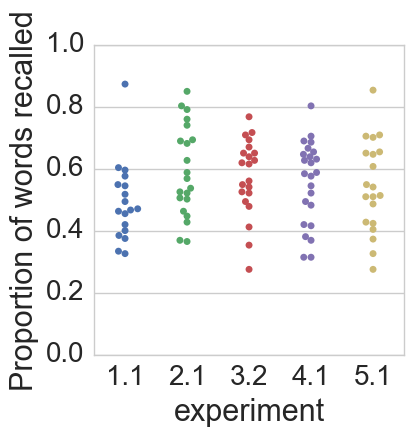

In [19]:
plt.figure(figsize=(4, 4))

data = fingerprintsDF2[(exp1 | exp2 | exp3 | exp4 | exp5)]
data = data.groupby(['subId','experiment']).mean().reset_index(level=['experiment'])
ax = sns.swarmplot(y='accuracy',x='experiment', data=data)
plt.ylabel('Proportion of words recalled')
plt.ylim(0,1)
plt.show()

In [20]:
import scipy.stats as stats

data_stats = [data[data['experiment']==exp]['value'].values for exp in data['experiment'].unique()]
print(stats.f_oneway(data_stats[0],data_stats[1],data_stats[2],data_stats[3],data_stats[4]))
for i1,expa in enumerate(data_stats):
    for i2,expb in enumerate(data_stats):
        print(i1,i2,stats.ttest_ind(expa,expb))

F_onewayResult(statistic=5.2239911080086001, pvalue=0.00073554632763144087)
(0, 0, Ttest_indResult(statistic=0.0, pvalue=1.0))
(0, 1, Ttest_indResult(statistic=-3.4865217719238593, pvalue=0.0012786027406593008))
(0, 2, Ttest_indResult(statistic=-0.43916667801291331, pvalue=0.66290411757884238))
(0, 3, Ttest_indResult(statistic=-1.2717534805564912, pvalue=0.21139660946529409))
(0, 4, Ttest_indResult(statistic=0.047652384365002173, pvalue=0.9622566666542296))
(1, 0, Ttest_indResult(statistic=3.4865217719238593, pvalue=0.0012786027406593008))
(1, 1, Ttest_indResult(statistic=0.0, pvalue=1.0))
(1, 2, Ttest_indResult(statistic=3.9585459765593516, pvalue=0.00027831818175549266))
(1, 3, Ttest_indResult(statistic=2.3442764451222819, pvalue=0.02411693019072279))
(1, 4, Ttest_indResult(statistic=3.8619831106876243, pvalue=0.00041277376569140862))
(2, 0, Ttest_indResult(statistic=0.43916667801291331, pvalue=0.66290411757884238))
(2, 1, Ttest_indResult(statistic=-3.9585459765593516, pvalue=0.00027

<h1>Avg. Recall, Early vs. Late</h1>

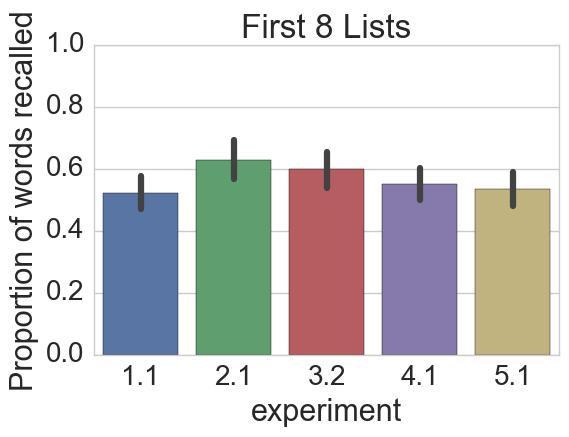

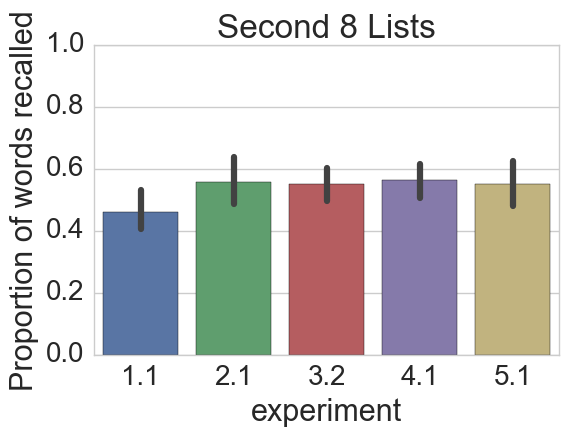

In [21]:
sns.set_style("whitegrid")
#plt.figure(figsize=(2,2))

#fig,ax = plt.subplot()
firsthalf = fingerprintsDF2['listNum']<=7
data = fingerprintsDF2[(exp1 | exp2 | exp3 | exp4 | exp5) & firsthalf].groupby(['subId','experiment']).mean().reset_index(level=['experiment'])
ax = sns.barplot(y='accuracy',x='experiment', data=data)
plt.ylabel('Proportion of words recalled')
plt.ylim(0,1)
ax.set_title('First 8 Lists')
plt.show()

secondhalf = fingerprintsDF2['listNum']>7
data = fingerprintsDF2[(exp1 | exp2 | exp3 | exp4 | exp5) & secondhalf].groupby(['subId','experiment']).mean().reset_index(level=['experiment'])
ax2 = sns.barplot(y='accuracy',x='experiment', data=data)
ax2.set_title('Second 8 Lists')
plt.ylabel('Proportion of words recalled')
plt.ylim(0,1)
plt.show()

# data_stats = [data[data['experiment']==exp and data['listNum']<=7]['value'].values for exp in data['experiment'].unique()]
# print(stats.f_oneway(data_stats[0],data_stats[1],data_stats[2],data_stats[3],data_stats[4]))
# for i1,expa in enumerate(data_stats):
#     for i2,expb in enumerate(data_stats):
#         print(i1,i2,stats.ttest_ind(expa,expb))



<h1> Avg. Fingerprint, All Experiments

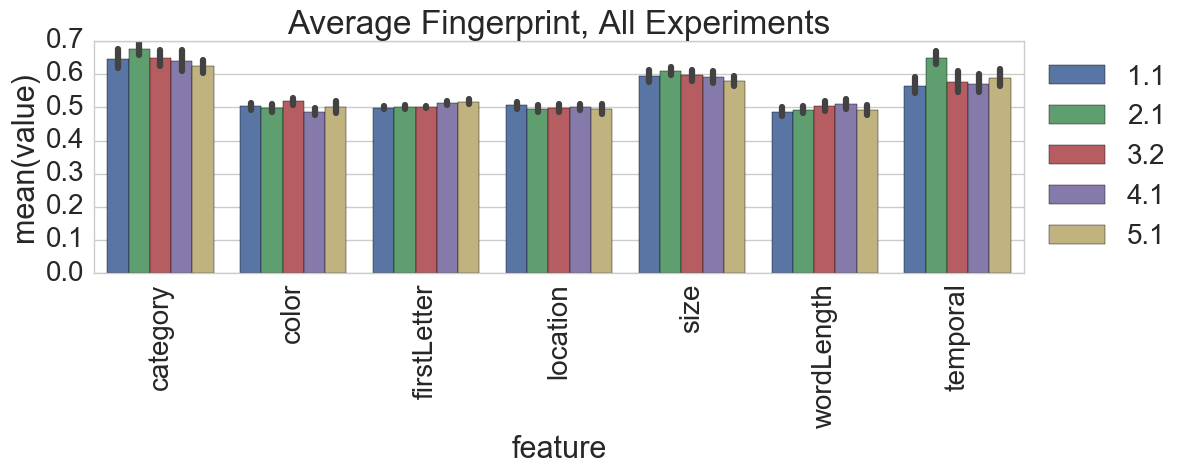

category
F_onewayResult(statistic=2.0801679724611581, pvalue=0.089076039799262638)
color
F_onewayResult(statistic=3.2447687417341204, pvalue=0.015141068151841552)
firstLetter
F_onewayResult(statistic=7.6175092000847995, pvalue=2.1559468388670102e-05)
location
F_onewayResult(statistic=0.46463888883815002, pvalue=0.76152486124651675)
size
F_onewayResult(statistic=1.5451843485003516, pvalue=0.19504719878711138)
wordLength
F_onewayResult(statistic=1.8441267902447365, pvalue=0.1263942126978202)
temporal
F_onewayResult(statistic=5.6786133874645186, pvalue=0.00037128659290283042)


In [24]:
import scipy.stats as stats

sns.set_style("whitegrid")
plt.figure(figsize=(12,3))

firsthalf = fingerprintsDF2['listNum']<=7
secondhalf = fingerprintsDF2['listNum']>7

data_all = exp1 + exp2 + exp3 + exp4 + exp5

data = fingerprintsDF2[data_all].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
ax = sns.barplot(hue = 'experiment', y='value', x='feature', data=data,order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
ax.set_title('Average Fingerprint, All Experiments')

sns.set_style("whitegrid")
plt.xticks(rotation='vertical')
plt.legend(loc='top')

#ax.set_position([box.x0,box.y0,box.width*0.9,box.height])
sns.plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
sns.plt.show()


#ANOVA#####

for feature in ['category','color','firstLetter','location','size','wordLength','temporal']:
    
    data1 = data[data['experiment']=='1.1']
    one = data1[data1['feature']==feature]['value'].values
        
    data2 = data[data['experiment']=='2.1']
    two = data2[data2['feature']==feature]['value'].values
    
    data3 = data[data['experiment']=='3.2']
    three = data3[data3['feature']==feature]['value'].values
    
    data4 = data[data['experiment']=='4.1']
    four = data4[data4['feature']==feature]['value'].values
    
    data5 = data[data['experiment']=='5.1']
    five = data5[data5['feature']==feature]['value'].values
    
    print(feature)
    print(stats.f_oneway(one, two, three, four, five))

# # the format you need is a variable for each experiment containing the value of the fingerprint for a given feature for each subject
# data1 = data[data['experiment']=='1.1']
# one = data1[data1['feature']=='category']['value'].values

<h1> Avg. Fingerprint, First vs Late (All Exps.)

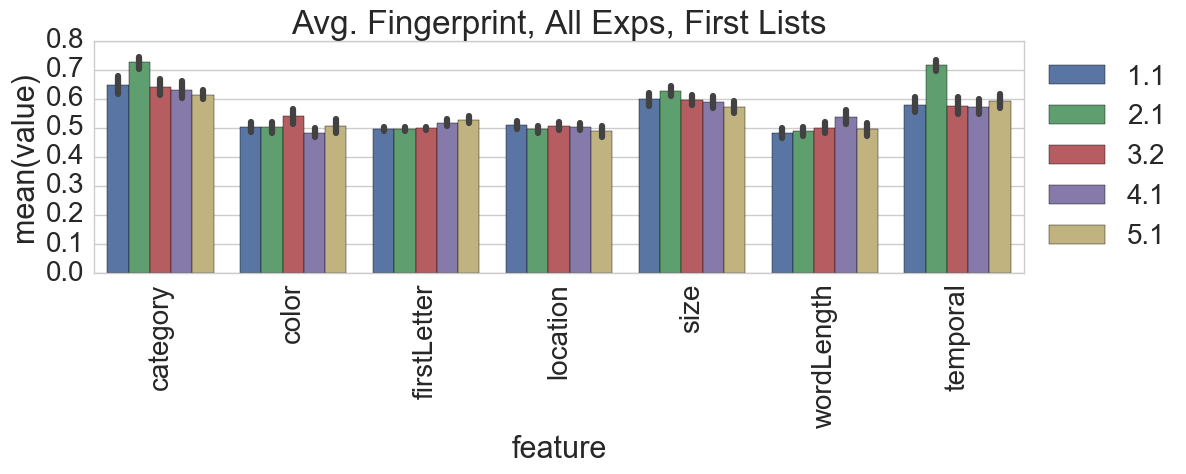

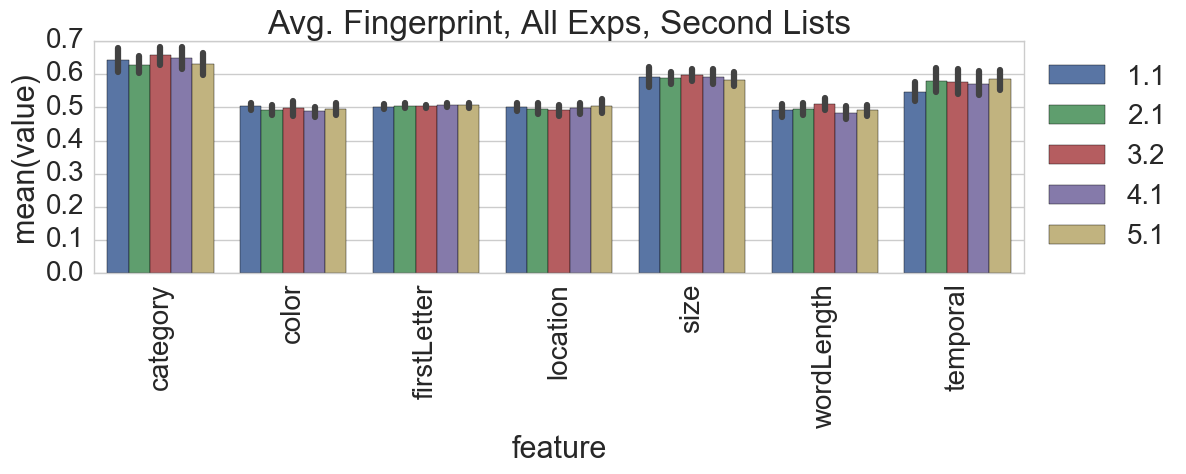

In [47]:
import scipy.stats as stats
import pyvttbl as pt

firsthalf = fingerprintsDF2['listNum']<=7
secondhalf = fingerprintsDF2['listNum']>7

# TO complete ANOVA:
# - average 

##FIRST PLOT

plt.figure(figsize=(12, 3))
data_all = exp1 + exp2 + exp3 + exp4 + exp5

data_early = fingerprintsDF2[(exp1 | exp2 | exp3 | exp4 | exp5) & firsthalf].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
ax = sns.barplot(hue = 'experiment', y='value', x='feature', data=data_early,order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
ax.set_title('Avg. Fingerprint, All Exps, First Lists')

sns.set_style("whitegrid")
plt.xticks(rotation='vertical')
plt.legend(loc='top')

#ax.set_position([box.x0,box.y0,box.width*0.9,box.height])
sns.plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
sns.plt.show()


##SECOND PLOT

plt.figure(figsize=(12, 3))
data_all = exp1 + exp2 + exp3 + exp4 + exp5


data_late = fingerprintsDF2[(exp1 | exp2 | exp3 | exp4 | exp5) & secondhalf].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
ax = sns.barplot(hue = 'experiment', y='value', x='feature', data=data_late,order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
ax.set_title('Avg. Fingerprint, All Exps, Second Lists')

sns.set_style("whitegrid")
plt.xticks(rotation='vertical')
plt.legend(loc='top')

#ax.set_position([box.x0,box.y0,box.width*0.9,box.height])
sns.plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
sns.plt.show()


#ANOVA#####

#for feature in ['category','color','firstLetter','location','size','wordLength','temporal']:
#    one = list(dict(list(fingerprintsDF.groupby('experiment')[feature]))['1.1'])
#    two = list(dict(list(fingerprintsDF.groupby('experiment')[feature]))['2.1'])
#    three = list(dict(list(fingerprintsDF.groupby('experiment')[feature]))['3.2'])
#    four = list(dict(list(fingerprintsDF.groupby('experiment')[feature]))['4.1'])
#    five = list(dict(list(fingerprintsDF.groupby('experiment')[feature]))['5.1'])
    
    
#    print(feature)
#    print(stats.f_oneway(one, two, three, four, five))
#    print



#for feature in ['category','color','firstLetter','location','size','wordLength','temporal']:
    
#    data1_early = firsthalf[firsthalf['experiment']=='1.1']
#    data1_late = secondhalf[secondhalf['experiment']=='1.1']
    
#    one_early = firsthalf[firsthalf['feature']==feature]['value'].values
#    one_late = secondhalf[secondhalf['feature']==feature]['value'].values
        
#    data2 = data[data['experiment']=='2.1']
#    two = data2[data2['feature']==feature]['value'].values
    
#    data3 = data[data['experiment']=='3.2']
#    three = data3[data3['feature']==feature]['value'].values
    
#    data4 = data[data['experiment']=='4.1']
#    four = data4[data4['feature']==feature]['value'].values
    
#    data5 = data[data['experiment']=='5.1']
#    five = data5[data5['feature']==feature]['value'].values
    
    
#    print(feature)
#    print(stats.f_oneway(one, two, three, four, five))



